In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal, gaussian_kde

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Plots
linewidth = 3.25063
SMALL_SIZE = 9
NORMAL_SIZE = 10
LARGE_SIZE = 14.4

plt.style.use('seaborn-white')
plt.rcParams['font.size'] = NORMAL_SIZE
plt.rcParams['axes.labelsize'] = NORMAL_SIZE
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = NORMAL_SIZE
plt.rcParams['ytick.labelsize'] = NORMAL_SIZE
plt.rcParams['legend.fontsize'] = NORMAL_SIZE
plt.rcParams['figure.titlesize'] = LARGE_SIZE
plt.rcParams['axes.axisbelow'] = True

# Latex

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def make_min_transparent(cmap, frac=.2, base_alpha=1):
    """Takes a colormap and replaces the color for the smallest values with transparent white."""
    n_colors = 256
    n_minvals = int(n_colors * frac)
    color_array = cmap(range(n_colors))
    color_array[:, -1] = base_alpha * np.ones(n_colors) # Set base transparency
    color_array[:n_minvals, :] = np.zeros((n_minvals, 4)) # Set lowest values to transparent white
    masked_cmap = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)
    return masked_cmap


def plot_priors(prior_fn, gibbs_fn, xlims=(0, 10), ylims=(-5, 5), n_levels=3, base_alpha=1, figsize=(2.7, 2.7), save_path=None):
    """Plots prior and gibbs marginal as heatmap plots."""
    # Make grid
    x = np.linspace(*xlims, 50)
    y = np.linspace(*ylims, 50)
    X, Y = np.meshgrid(x, y)
    prior_vals = np.zeros_like(X)
    gibbs_vals = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            theta = np.array([X[i, j], Y[i, j]])
            prior_vals[i, j] = prior_fn(theta)
            gibbs_vals[i, j] = gibbs_fn(theta)

    # Make plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    # Plot target density
    cmap_prior = make_min_transparent(plt.cm.get_cmap("Blues"), base_alpha=base_alpha)
    cmap_gibbs = make_min_transparent(plt.cm.get_cmap("Reds"), base_alpha=base_alpha)
    ax.contourf(X, Y, prior_vals, cmap=cmap_prior, levels=n_levels)
    ax.contourf(X, Y, gibbs_vals, cmap=cmap_gibbs, levels=n_levels)

    ax.set_xticklabels([0])
    ax.set_yticklabels([0])
    # ax.text(-.5, -.5, '0')
    legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Chosen prior'),
                       Line2D([0], [0], color='red', lw=2, label='Used prior')]
    ax.legend(handles=legend_elements)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    return

def eval_grid(X, Y, fn):
    """Evaluate grid specified by xs x ys at function fn"""
    vals = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            theta = np.array([X[i, j], Y[i, j]])
            vals[i, j] = fn(theta)
    return vals

In [3]:
class Sketch(object):
    """Class containing all information that are relevant for the prior sketch in the introduction."""
    def __init__(self, marginal_loc, marginal_scale, mean_fn, scale_fn, cov_like, shrinkage_factor=.85, n_samples=100, y_obs=None):
        """Collect necessary information for specifying prior distribution and likelihood."""
        self.marginal_loc = marginal_loc
        self.marginal_scale = marginal_scale
        self.mean_fn = mean_fn
        self.scale_fn = scale_fn
        self.cov_like = cov_like

        # print('Sampling Gibbs prior')
        self.samples_Gibbs_prior = self.generate_gibbs_sequence(T=n_samples, shrinkage_factor=shrinkage_factor, verbose=True)

        if y_obs is None:
            theta = self.sample_prior()
            y_obs = self.sample_like(theta)
        print(f'Sampling posterior at y={y_obs}')
        self.samples_posterior = self.sample_posterior(y_obs, n_samples=n_samples)
        print(f'Sampling approximation to posterior at y={y_obs}')
        self.samples_approx = self.sample_posterior(y_obs, shrinkage_factor=shrinkage_factor, n_samples=n_samples)

    def visualize_hyperparams(self):
        """Creates a plot that visualizes the chosen hyperparameters."""
        # Visualize marginal, means, and variances
        fig, axs = plt.subplots(figsize=(12, 12))

        ts = np.linspace(2, 8, 60)
        marg_vals = [norm.pdf(t, loc=self.marginal_loc, scale=self.marginal_scale) for t in ts]
        mean_vals = [self.mean_fn(t) for t in ts]
        scale_vals = [self.scale_fn(t) for t in ts]

        axs.plot(ts, marg_vals, label='marginal\_fn')
        axs.plot(ts, mean_vals, label='mean\_fn')
        axs.plot(ts, scale_vals, label='variance\_fn')
        plt.legend()
        plt.show()
        return

    def prior_density(self, theta):
        """Evaluate prior density at a given point theta=(x_1,x_2)."""
        x_1, x_2 = theta
        p_x1 = norm.pdf(x_1, loc=self.marginal_loc, scale=self.marginal_scale)
        p_x2 = norm.pdf(x_2, loc=self.mean_fn(x_1), scale=self.scale_fn(x_1))
        return p_x1 * p_x2

    def like_density(self, y, theta):
        """Evaluate likelihood density f(y|theta)."""
        return multivariate_normal.pdf(y, mean=theta, cov=self.cov_like)

    def sample_prior(self, n_samples=1):
        """Sample from prior distribution."""
        x_1 = norm.rvs(loc=self.marginal_loc, scale=self.marginal_scale, size=(n_samples, 1))
        x_2 = norm.rvs(loc=self.mean_fn(x_1), scale=self.scale_fn(x_1), size=(n_samples, 1))
        theta = np.concatenate([x_1, x_2], axis=-1)
        return theta.squeeze()

    def sample_like(self, theta, n_samples=1):
        """Sample from likelihood conditioned on theta."""
        return multivariate_normal.rvs(mean=theta, cov=self.cov_like)

    def sample_posterior(self, y, envelope_scale=2, verbose=False, shrinkage_factor=1, n_samples=1):
        """Sample from the posterior to an observation y based on rejection sampling with the prior as candidate density."""
        samples = np.zeros((n_samples, 2))
        # Rejection sampling with prior as proposal density
        for i in range(n_samples):
            u = 1
            threshold = 0
            counter = 0
            while u >= threshold:
                theta = self.sample_prior().squeeze()
                u = np.random.uniform()
                threshold = 2 * np.pi / envelope_scale * self.like_density(y=y, theta=theta)
                counter += 1
            if verbose:
                print(counter)
            samples[i] = shrinkage_factor * theta
        return samples.squeeze()

    def generate_gibbs_sequence(self, T=100, shrinkage_factor=1, verbose=False):
        """Generates a gibbs sequence with initialization drawn from prior."""
        theta = self.sample_prior()
        gibbs_sequence = np.zeros((T, 2))
        for t in range(T):
            y = self.sample_like(theta)
            theta = self.sample_posterior(y, shrinkage_factor=shrinkage_factor)
            gibbs_sequence[t, :] = theta
            if verbose:
                if t % 100 == 0:
                    print(f'Step {t}')
        return gibbs_sequence

    def plot(self, xlims=(0, 10), ylims=(-5, 5), n_levels=3, base_alpha=1, figsize=(2.7, 2.7),
             show_legend=True, save_path=None):
        """Plots prior and gibbs marginal as heatmap plots."""
        # Density functions
        gibbs_fn = gaussian_kde(self.samples_Gibbs_prior.T)
        prior_fn = self.prior_density
        posterior_fn = gaussian_kde(self.samples_posterior.T)
        approx_fn = gaussian_kde(self.samples_approx.T)

        # Make grid and evaluate
        x = np.linspace(*xlims, 50)
        y = np.linspace(*ylims, 50)
        X, Y = np.meshgrid(x, y)

        prior_vals = eval_grid(X, Y, prior_fn)
        gibbs_vals = eval_grid(X, Y, gibbs_fn)
        posterior_vals = eval_grid(X, Y, posterior_fn)
        approx_vals = eval_grid(X, Y, approx_fn)


        # Make plot
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        ax_prior, ax_posterior = axs

        # Priors
        cmap_prior = make_min_transparent(plt.cm.get_cmap("Blues"), base_alpha=base_alpha)
        cmap_gibbs = make_min_transparent(plt.cm.get_cmap("Reds"), base_alpha=base_alpha)
        ax_prior.contourf(X, Y, prior_vals, cmap=cmap_prior, levels=n_levels)
        ax_prior.contourf(X, Y, gibbs_vals, cmap=cmap_gibbs, levels=n_levels)

        ax_prior.set_xticklabels([0])
        ax_prior.set_yticklabels([0])
        # ax.text(-.5, -.5, '0')
        legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Explicitly chosen prior'),
                           Line2D([0], [0], color='red', lw=2, label='Implicitly used prior')]
        if show_legend:
            ax_prior.legend(handles=legend_elements)

        # Posteriors
        cmap_posterior = make_min_transparent(plt.cm.get_cmap("Blues"), base_alpha=base_alpha)
        cmap_approx = make_min_transparent(plt.cm.get_cmap("Reds"), base_alpha=base_alpha)
        ax_posterior.contourf(X, Y, posterior_vals, cmap=cmap_posterior, levels=n_levels)
        ax_posterior.contourf(X, Y, approx_vals, cmap=cmap_approx, levels=n_levels)

        ax_posterior.set_xticklabels([0])
        ax_posterior.set_yticklabels([0])
        legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Posterior'),
                           Line2D([0], [0], color='red', lw=2, label='Approximate posterior')]
        if show_legend:
            ax_posterior.legend(handles=legend_elements)

        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        return

In [4]:
# Choose hyperparameters for the sketch and initialize model
np.random.seed(0)
marginal_loc, marginal_scale = 5, 2
mean_fn = lambda x: -.8 * np.sin(1.3 * x + 4) - .4 * x + 5.5
scale_fn = lambda x: 0.3 * np.sin(.4 * x) ** 2 + 1
cov_like = np.eye(2)

sketch = Sketch(marginal_loc=marginal_loc, marginal_scale=marginal_scale, mean_fn=mean_fn, scale_fn=scale_fn,
                cov_like=cov_like,
                shrinkage_factor=.85,
                n_samples=1000,
                y_obs=np.array([5.40, 3.02]))

Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Sampling posterior at y=[5.4  3.02]
Sampling approximation to posterior at y=[5.4  3.02]


In [5]:
# Density functions
gibbs_fn = gaussian_kde(sketch.samples_Gibbs_prior.T)
prior_fn = sketch.prior_density
posterior_fn = gaussian_kde(sketch.samples_posterior.T)
approx_fn = gaussian_kde(sketch.samples_approx.T)

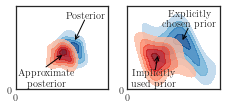

In [6]:
# Input
xlims = (0, 9)
ylims = (0, 7)
n_levels = 5
base_alpha = .8
figsize = (linewidth, .5 * linewidth)
show_legend = False
save_path = '../fig/intro_schematic_norm.pdf'

# Make grid and evaluate
x = np.linspace(*xlims, 50)
y = np.linspace(*ylims, 50)
X, Y = np.meshgrid(x, y)

prior_vals = eval_grid(X, Y, prior_fn)
gibbs_vals = eval_grid(X, Y, gibbs_fn)
posterior_vals = eval_grid(X, Y, posterior_fn)
approx_vals = eval_grid(X, Y, approx_fn)


# Make plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
ax_posterior, ax_prior = axs

# Priors
cmap_prior = make_min_transparent(plt.cm.get_cmap("Blues"), base_alpha=base_alpha)
cmap_gibbs = make_min_transparent(plt.cm.get_cmap("Reds"), base_alpha=base_alpha)
ax_prior.contourf(X, Y, prior_vals, cmap=cmap_prior, levels=n_levels)
ax_prior.contourf(X, Y, gibbs_vals, cmap=cmap_gibbs, levels=n_levels)

for i, tick in enumerate(ax_prior.xaxis.get_major_ticks()):
    if i != 0:
        tick.label1.set_visible(False)
for i, tick in enumerate(ax_prior.yaxis.get_major_ticks()):
    if i != 0:
        tick.label1.set_visible(False)

if show_legend:
    legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Explicitly chosen prior'),
                       Line2D([0], [0], color='red', lw=2, label='Implicitly used prior')]
    ax_prior.legend(handles=legend_elements)

# Text
ax_prior.annotate(text='Explicitly\n chosen prior', xy=(5.3, 4), xytext=(6, 5.3), ha='center')
ax_prior.annotate(text='', xy=(5.3, 4), xytext=(6, 5.3), arrowprops={'arrowstyle':'->'})
ax_prior.annotate(text='Implicitly\n used prior', xy=(3, 3), xytext=(2.5, .3), ha='center')
ax_prior.annotate(text='', xy=(3, 3), xytext=(2.7, 1.5), arrowprops={'arrowstyle':'->'})


## Posteriors
cmap_posterior = make_min_transparent(plt.cm.get_cmap("Blues"), base_alpha=base_alpha)
cmap_approx = make_min_transparent(plt.cm.get_cmap("Reds"), base_alpha=base_alpha)
ax_posterior.contourf(X, Y, posterior_vals, cmap=cmap_posterior, levels=n_levels)
ax_posterior.contourf(X, Y, approx_vals, cmap=cmap_approx, levels=n_levels)

for i, tick in enumerate(ax_posterior.xaxis.get_major_ticks()):
    if i != 0:
        tick.label1.set_visible(False)
for i, tick in enumerate(ax_posterior.yaxis.get_major_ticks()):
    if i != 0:
        tick.label1.set_visible(False)
# ax.text(-.5, -.5, '0')
if show_legend:
    legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Posterior'),
                       Line2D([0], [0], color='red', lw=2, label='Approximate posterior')]
    ax_posterior.legend(handles=legend_elements)

# Text
ax_posterior.annotate(text='Posterior', xy=(5.7, 4), xytext=(6.8,6), ha='center')
ax_posterior.annotate(text='', xy=(5.7, 4), xytext=(6.8,6), arrowprops={'arrowstyle':'->'})
ax_posterior.annotate(text='Approximate\n posterior', xy=(5, 3), xytext=(3, .3), ha='center')
ax_posterior.annotate(text='', xy=(4.7, 3), xytext=(2.8, 1.8), arrowprops={'arrowstyle':'->'})

plt.tight_layout()
if save_path is not None:
    plt.savefig(save_path, bbox_inches='tight')
plt.show()